In [8]:
import cv2
import numpy as np
from typing import List, Tuple, Union, Optional
from IPython.display import Image
import matplotlib.pyplot as plt


In [ ]:
def find_harris_corners(
    input_img: np.ndarray[np.uint8],
    k: float = 0.04,
    window_size: int = 5,
    threshold: float = 10000.00
) -> Tuple[List[List[Union[int, float]]], np.ndarray]:
    """
    Detect Harris corners in the input grayscale image.
    Returns:
        corner_list: List of detected corners as [x, y, response_value]
        output_img: Original image with detected corners marked in red
    """
    corner_list = []
    window_size = window_size | 1   # round up to odd number

    # Create a copy for visualization
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)

    # 1. Apply Gaussian blur, then calculate gradient
    # Smaller sigma value for more subtle blur
    # TODO: implement own sobel?
    blurred_img = cv2.GaussianBlur(input_img, (3, 3), 0.8)

    dx = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=5)

    # 3=2. Compute products of derivatives
    i_xx = dx ** 2
    i_xy = dy * dx
    i_yy = dy ** 2

    # 3. Pad the gradient images with 101 reflection
    offset = int(window_size / 2)
    i_xx_padded = cv2.copyMakeBorder(i_xx, offset, offset, offset, offset, cv2.BORDER_REFLECT_101)
    i_xy_padded = cv2.copyMakeBorder(i_xy, offset, offset, offset, offset, cv2.BORDER_REFLECT_101)
    i_yy_padded = cv2.copyMakeBorder(i_yy, offset, offset, offset, offset, cv2.BORDER_REFLECT_101)

    # 4. Compute corner response for all pixels
    height, width = input_img.shape
    for y in range(height):
        for x in range(width):
            # Extract window from padded gradient images
            # Add offset to coordinates to account for padding
            # Note: we can now use fixed window size without boundary checks
            window_i_xx = i_xx_padded[y:y + window_size, x:x + window_size]
            window_i_xy = i_xy_padded[y:y + window_size, x:x + window_size]
            window_i_yy = i_yy_padded[y:y + window_size, x:x + window_size]

            # Calculate elements of structure tensor M
            sum_xx = window_i_xx.sum()
            sum_xy = window_i_xy.sum()
            sum_yy = window_i_yy.sum()

            # Calculate determinant and trace
            det = (sum_xx * sum_yy) - (sum_xy ** 2)
            trace = sum_xx + sum_yy

            # Calculate Harris corner response
            r = det - k * (trace ** 2)

            # Thresholding to find corners
            if r > threshold:
                corner_list.append([x + offset, y + offset, r])  # Store coordinates and response value
                output_img[y, x] = (0, 0, 255)  # Mark corner in red for visualization

    return corner_list, output_img


(384, 512)


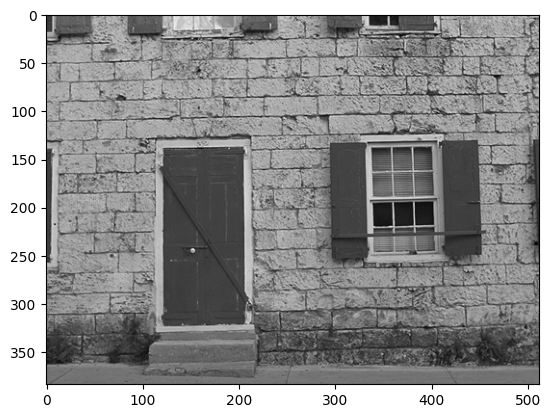

In [11]:
input_img = cv2.imread("tid2013/reference_images/I01.BMP", cv2.IMREAD_GRAYSCALE)
print(input_img.shape)
plt.imshow(input_img, cmap='gray')
plt.show()
